In [1]:
import pandas as pd

c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
df = pd.read_csv('../data/Finalplfam_id_Multilabel_Ecoli_data.csv', index_col=0)

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (6,18,29,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:

Y=df[['ampicillin',
       'amoxicillin_clavulanic_acid', 'cefoxitin', 'ceftriaxone',
       'chloramphenicol', 'ciprofloxacin', 'gentamicin', 'streptomycin',
       'tetracycline', 'trimethoprim_sulphamethoxazole', 'meropenem',
       'cefepime', 'ceftazidime', 'piperacillin_tazobactam', 'amikacin',
       'ampicillin_sulbactam', 'cefotaxime', 'cefalothin', 'ertapenem',
       'imipenem', 'levofloxacin', 'nitrofurantoin', 'tigecycline',
       'cefazolin', 'aztreonam', 'cefuroxime', 'tobramycin',
       'trimethoprim', 'amoxicillin', 'colistin', 'norfloxacin',
       'sulfamethoxazole']]
droppeddf=df.drop(columns=['genome_id', 'genome_name', 'taxon_id', 'ampicillin',
       'amoxicillin_clavulanic_acid', 'cefoxitin', 'ceftriaxone',
       'chloramphenicol', 'ciprofloxacin', 'gentamicin', 'streptomycin',
       'tetracycline', 'trimethoprim_sulphamethoxazole', 'meropenem',
       'cefepime', 'ceftazidime', 'piperacillin_tazobactam', 'amikacin',
       'ampicillin_sulbactam', 'cefotaxime', 'cefalothin', 'ertapenem',
       'imipenem', 'levofloxacin', 'nitrofurantoin', 'tigecycline',
       'cefazolin', 'aztreonam', 'cefuroxime', 'tobramycin',
       'trimethoprim', 'amoxicillin', 'colistin', 'norfloxacin',
       'sulfamethoxazole'])
X=droppeddf

In [4]:
# set the seeds so that we get the same initialization across different trials
seed_numpy = 1989
seed_tensorflow = 1989
seed_value=1989

In [5]:
import numpy as np
import tensorflow as tf
from keras import backend as K

In [6]:
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
import random
import os

random.seed(seed_numpy)
tf.compat.v1.random.set_random_seed(seed_tensorflow)
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [8]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1989)

In [9]:
X.shape

(2775, 16345)

In [10]:
def make_model(train_features, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(1000, activation='relu', input_shape=(train_features.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(256, activation='relu'), #LeakyReLU
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'), #LeakyReLU
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(32, activation='sigmoid',bias_initializer=output_bias),# activation='softmax' don;t use softmax
  ])

    return model

In [11]:
labels=['ampicillin',
       'amoxicillin_clavulanic_acid', 'cefoxitin', 'ceftriaxone',
       'chloramphenicol', 'ciprofloxacin', 'gentamicin', 'streptomycin',
       'tetracycline', 'trimethoprim_sulphamethoxazole', 'meropenem',
       'cefepime', 'ceftazidime', 'piperacillin_tazobactam', 'amikacin',
       'ampicillin_sulbactam', 'cefotaxime', 'cefalothin', 'ertapenem',
       'imipenem', 'levofloxacin', 'nitrofurantoin', 'tigecycline',
       'cefazolin', 'aztreonam', 'cefuroxime', 'tobramycin',
       'trimethoprim', 'amoxicillin', 'colistin', 'norfloxacin',
       'sulfamethoxazole']

In [12]:
X=X.fillna(0)

In [13]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metric(history, labels, n,metrics):
  # Use a log scale to show the wide range of values.
  for metric in metrics:
        plt.semilogy(history.epoch, history.history[metric],
                color=colors[n], label='Train '+labels[n])
        plt.semilogy(history.epoch, history.history['val_'+metric],
                color=colors[n], label='Val '+labels[n],
                linestyle="--")
        n=n+1
  plt.xlabel('Epoch')
  plt.ylabel('Metrics')

  plt.legend()
  plt.savefig('../output/'+'Plot_masked_'.join(labels)+'.png')

In [14]:
mask_value=-1

In [15]:
def masked_accuracy(y_true, y_pred):
    dtype = K.floatx()
    total = K.sum(K.cast(K.not_equal(y_true, mask_value), dtype))
    #total=K.cast(len(y_true),dtype)
    correct = K.sum(K.cast(K.equal(y_true, K.round(y_pred)), dtype))
    #print(correct,total)
    return correct / total

In [16]:
from sklearn.utils import class_weight

In [17]:
def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    #print(mask)
    return K.binary_crossentropy(y_true * mask, y_pred * mask)

In [18]:
def masked_f1(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred*mask, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true*mask, 0, 1)))

        recall = TP / (Positives+K.epsilon())    
        return recall 


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred *mask, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred*mask, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision 

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))
  

In [19]:
def masked_precision(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    TP = K.sum(K.round(K.clip(y_true * y_pred *mask, 0, 1)))
    Pred_Positives = K.sum(K.round(K.clip(y_pred*mask, 0, 1)))

    precision = TP / (Pred_Positives+K.epsilon())
    return precision 

In [20]:

def masked_recall(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    TP = K.sum(K.round(K.clip(y_true * y_pred*mask, 0, 1)))
    Positives = K.sum(K.round(K.clip(y_true*mask, 0, 1)))

    recall = TP / (Positives+K.epsilon())    
    return recall 

In [21]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      masked_accuracy,
      masked_precision,
      masked_recall,
      masked_f1
]

In [22]:
EPOCHS = 50
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_masked_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [23]:


accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
flist=[]
for train_index, test_index in kfold.split(X, Y):
    # split data into train/test sets
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_test_tfidf = X.iloc[test_index]
    y_test_tfidf = Y.iloc[test_index]
    trainX, validateX, trainyp, validatey = train_test_split(x_train_tfidf, y_train_tfidf, test_size=0.2, random_state=1989)
    trainyp=trainyp.reset_index(drop=True)
    trainX=trainX.reset_index(drop=True)
    validatey=validatey.reset_index(drop=True)
    validateX=validateX.reset_index(drop=True)

    
    trainy=trainyp.fillna(-1)
    validatey=validatey.fillna(-1)
    Testy=pd.DataFrame(y_test_tfidf).fillna(-1)

    trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
    train_labels = np.array(trainy).astype(np.float32)
    val_labels = np.array(validatey).astype(np.float32)
    test_labels = np.array(Testy).astype(np.float32)
    train_features = np.array(trainX).astype(np.float32)
    val_features = np.array(validateX).astype(np.float32)
    test_features = np.array(x_test_tfidf).astype(np.float32)
    
    #weight2=weight[:,1:3]
    model = make_model(train_features)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)
    #model.summary()
    baseline_history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))
    
    # calculating test accuracy
    results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=1)
    print (results)
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    flist.append(results[4])
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

Epoch 1/50
56/56 [==============================] - 4s 48ms/step - loss: 0.2661 - masked_accuracy: 0.6121 - masked_precision: 0.3988 - masked_recall: 0.4938 - masked_f1: 0.4357 - val_loss: 0.1848 - val_masked_accuracy: 0.7110 - val_masked_precision: 0.5594 - val_masked_recall: 0.4338 - val_masked_f1: 0.4846
Epoch 2/50
56/56 [==============================] - 2s 43ms/step - loss: 0.1706 - masked_accuracy: 0.7042 - masked_precision: 0.5240 - masked_recall: 0.4783 - masked_f1: 0.4955 - val_loss: 0.1566 - val_masked_accuracy: 0.7446 - val_masked_precision: 0.6357 - val_masked_recall: 0.4663 - val_masked_f1: 0.5335
Epoch 3/50
56/56 [==============================] - 2s 44ms/step - loss: 0.1529 - masked_accuracy: 0.7421 - masked_precision: 0.5952 - masked_recall: 0.5067 - masked_f1: 0.5442 - val_loss: 0.1422 - val_masked_accuracy: 0.7755 - val_masked_precision: 0.7345 - val_masked_recall: 0.4625 - val_masked_f1: 0.5648
Epoch 4/50
56/56 [==============================] - 2s 43ms/step - loss: 

In [24]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

0.8275404572486877 0.01408760755472451 0.725950821240743 0.03131290430457557 0.6926020503044128 0.038265895598613736 0.7048559983571371 0.023916414806292256


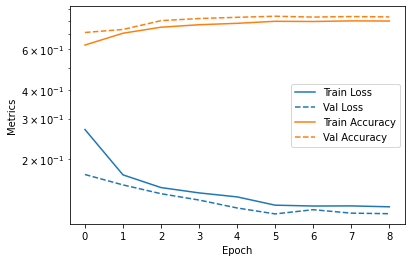

In [25]:
plot_metric(baseline_history, ['Loss','Accuracy'], 0,['loss','masked_accuracy'])

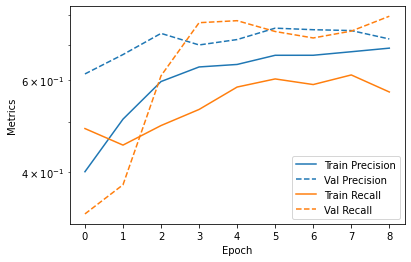

In [26]:
plot_metric(baseline_history, ['Precision','Recall'], 0,['masked_precision','masked_recall'])

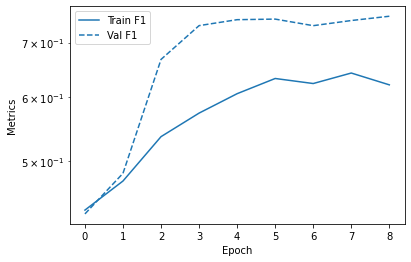

In [28]:
plot_metric(baseline_history, ['F1'], 0,['masked_f1'])

In [29]:
output_dir='../output/'

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Dropout, MaxPooling1D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
def build_conv1D_model(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1] #13
    n_features  = train_data_reshaped.shape[2] #1 
    model = Sequential(name="model_conv1D")
    model.add(Input(shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu', name="Dense_1"))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', name="Dense_1_1"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu',name="Dense_2"))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='sigmoid',name="Dense_3"))
   # model.add(Dense(n_labels, name="Dense_2"))

    return model


In [32]:
import shap

In [33]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
flist=[]
for train_index, test_index in kfold.split(X, Y):
    # split data into train/test sets
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_test_tfidf = X.iloc[test_index]
    y_test_tfidf = Y.iloc[test_index]
    trainX, validateX, trainyp, validatey = train_test_split(x_train_tfidf, y_train_tfidf, test_size=0.2, random_state=1989)
    trainyp=trainyp.reset_index(drop=True)
    trainX=trainX.reset_index(drop=True)
    validatey=validatey.reset_index(drop=True)
    validateX=validateX.reset_index(drop=True)

    
    trainy=trainyp.fillna(-1)
    validatey=validatey.fillna(-1)
    Testy=pd.DataFrame(y_test_tfidf).fillna(-1)

    trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
    train_labels = np.array(trainy).astype(np.float32)
    val_labels = np.array(validatey).astype(np.float32)
    test_labels = np.array(Testy).astype(np.float32)
    train_features = np.array(trainX).astype(np.float32)
    val_features = np.array(validateX).astype(np.float32)
    test_features = np.array(x_test_tfidf).astype(np.float32)
    
    input_dimension = 1 
    train_sample_size = trainX.shape[0] # number of samples in train set
    test_sample_size = x_test_tfidf.shape[0] # number of samples in train set
    valid_sample_size = validateX.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.shape[1] # number of features in train set

    test_data_reshaped = test_features.reshape(test_sample_size,time_steps,input_dimension)
    train_data_reshaped = train_features.reshape(train_sample_size,time_steps,input_dimension)
    val_data_reshaped = val_features.reshape(valid_sample_size,time_steps,input_dimension)

    #weight2=weight[:,1:3]
    model = build_conv1D_model(train_data_reshaped)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)
    #model.summary()
    '''explaincallbacks = [
    GradientsInputsCallback(
        validation_data=(val_data_reshaped, val_labels),
         class_index=0,
        output_dir=output_dir,
    ),
]'''
    baseline_history = model.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))
    
    # calculating test accuracy
    results = model.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
    #print (results)
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    flist.append(results[4])
    #explainer = shap.DeepExplainer(model,train_data_reshaped)
    #shap_values = explainer.shap_values(test_data_reshaped)
    #print (shap_values)
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

Epoch 1/50
56/56 [==============================] - 45s 786ms/step - loss: 0.1820 - masked_accuracy: 0.6997 - masked_precision: 0.5284 - masked_recall: 0.4521 - masked_f1: 0.4797 - val_loss: 0.1576 - val_masked_accuracy: 0.7695 - val_masked_precision: 0.7158 - val_masked_recall: 0.4587 - val_masked_f1: 0.5564
Epoch 2/50
56/56 [==============================] - 44s 781ms/step - loss: 0.1349 - masked_accuracy: 0.7843 - masked_precision: 0.6731 - masked_recall: 0.5769 - masked_f1: 0.6172 - val_loss: 0.1224 - val_masked_accuracy: 0.8328 - val_masked_precision: 0.7647 - val_masked_recall: 0.6737 - val_masked_f1: 0.7155
Epoch 3/50
56/56 [==============================] - 44s 787ms/step - loss: 0.1131 - masked_accuracy: 0.8279 - masked_precision: 0.7346 - masked_recall: 0.6864 - masked_f1: 0.7078 - val_loss: 0.1116 - val_masked_accuracy: 0.8477 - val_masked_precision: 0.8147 - val_masked_recall: 0.6650 - val_masked_f1: 0.7305
Epoch 4/50
56/56 [==============================] - 43s 775ms/step 

In [34]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

0.8867341121037801 0.007733993850629148 0.8258042772610982 0.021431417544909907 0.7933093468348186 0.013257446195165515 0.8068358540534973 0.01209331610593186


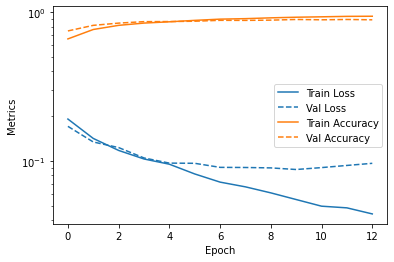

In [35]:
plot_metric(baseline_history, ['Loss','Accuracy'], 0,['loss','masked_accuracy'])

In [36]:
model.save('../output/maskmodel.h5')